# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [1]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from api import Benchmark

In [74]:
bench_dir = "cached/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [75]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


#### Data Analysis and Cleaning

In [76]:
def removeUninformativeFeatures(train_data): 
    store_config = {}
    informative_config = {}
    uninformative_config = {}

    for indx in range(len(train_data)):
        for value, key in train_data[indx]["config"].items():
            store_config[value] = []
    print("Seeking for uninformative data...")
    print()

    for value in store_config:
        for i in range(len(train_data)):
            for value_inner, key in train_data[i]["config"].items():
                store_config[value_inner].append(key)

        nTemp = store_config[value][0]
        bEqual = True
        for item in store_config[value]:
            if nTemp != item:
                bEqual = False
                break;
        if bEqual:
            print("All elements in list "+value+" are EQUAL")
            uninformative_config[value] = store_config[value]
        else:
            print("All elements in list "+value+" are different")
            informative_config[value] = store_config[value]

    print()
    print("Only "+str(len(informative_config))+"/"+str(len(store_config))+" parameters are informative.")
    print("Removing uninformative parameters from dataset...")        
    train_data_clean = train_data.copy()
    print(len(train_data))
    for i in range(len(train_data)):
        for value, key in uninformative_config.items():
            train_data_clean[i]["config"].pop(value)
            
    return train_data_clean

In [77]:
train_data_clean = removeUninformativeFeatures(train_data)
val_data_clean = removeUninformativeFeatures(val_data)

Seeking for uninformative data...

All elements in list batch_size are different
All elements in list imputation_strategy are EQUAL
All elements in list learning_rate_scheduler are EQUAL
All elements in list loss are EQUAL
All elements in list network are EQUAL
All elements in list max_dropout are different
All elements in list normalization_strategy are EQUAL
All elements in list optimizer are EQUAL
All elements in list cosine_annealing_T_max are EQUAL
All elements in list cosine_annealing_eta_min are EQUAL
All elements in list activation are EQUAL
All elements in list max_units are different
All elements in list mlp_shape are EQUAL
All elements in list num_layers are different
All elements in list learning_rate are different
All elements in list momentum are different
All elements in list weight_decay are different

Only 7/17 parameters are informative.
Removing uninformative parameters from dataset...
1000
Seeking for uninformative data...

All elements in list batch_size are differ

In [148]:
def DictToTensor (X, name_data):
    dim_config = len(X[0][name_data])
    data_torch = torch.zeros(len(X), dim_config)
    for i in range(len(X)):
        j = 0
        for _, key in X[i][name_data].items():
            data_torch[i,j] = key
            j+=1
    return data_torch

In [149]:
train_data_tensor = DictToTensor(train_data_clean, "config")
val_data_tensor = DictToTensor(val_data_clean, "config")
train_targets = torch.FloatTensor(train_targets).reshape(-1,1)
val_targets = torch.FloatTensor(val_targets).reshape(-1,1)

##### First Model


In [150]:
import torch.nn as nn

class FirstNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super(FirstNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, 1) 

        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        
        return x


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [147]:
#training Loop

import torch.optim as optim
import torch
from sklearn.metrics import mean_squared_error

max_epochs = 100
input_size = train_data_tensor.shape[1]
model = FirstNet(input_size)
# Define a Loss function and optimizer
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(max_epochs):
    running_loss = 0.0
    optimizer.zero_grad()
    outputs = model(train_data_tensor)
    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if epoch%10 ==0:
        print(str(epoch)+"/"+str(max_epochs)+" loss : ", running_loss)
        running_loss = 0.
print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    predicted = model(val_data_tensor)
    score = mean_squared_error(predicted, val_targets)

print('MSE of the network on the 1000 data config: ', score)

0/100 loss :  7157.49169921875
10/100 loss :  nan
20/100 loss :  nan
30/100 loss :  nan
40/100 loss :  nan
50/100 loss :  nan
60/100 loss :  nan
70/100 loss :  nan
80/100 loss :  nan
90/100 loss :  nan
Finished Training


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [142]:
# Config
print("Config example:", train_data[0]["config"])

Config example: {'batch_size': 71, 'max_dropout': 0.025926231827891333, 'max_units': 293, 'num_layers': 3, 'learning_rate': 0.0018243300267253295, 'momentum': 0.21325193168301043, 'weight_decay': 0.020472816917443872}


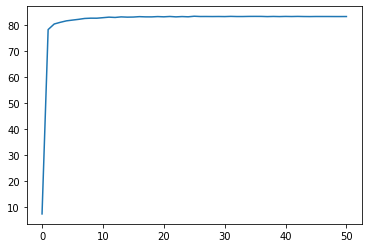

In [21]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

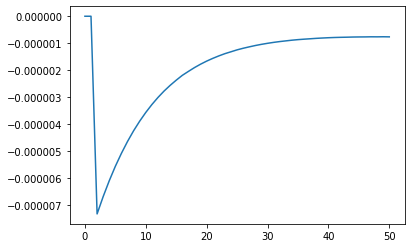

In [22]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

## A simple baseline

In [30]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [31]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

Score on validation set: 31.921338670622784


In [32]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)

Final test score: 24.199496266785523
